PROGETTO: CREAZIONE DI UNA RETE NEURALE OCR IN GRADO DI FARE UNA DETECTION SU TARGHE DI AUTOVEICOLI.

In [4]:
#Import delle varie librerie.
import pandas as pd     #libreria per manipolazione e analisi dei dati
import numpy as np      #libreria per array multidimensionali nparray
import matplotlib.pyplot as plt   #libreria per fare i plot(grafici)
import cv2    #libreria per la computer vision
import os     #libreria per lavorare con il sistema operativo
import glob   #libreria per ricercare file sui paths.
from IPython.display import display, Image
import tensorflow as tf
import xml.etree.ElementTree as etree #libreria per scorrere i file xml
import copy as cp #libreria per copiare le immagin
from sklearn.model_selection import train_test_split #libreria per splittare il dataset
#libreria per creazione del modello cnn nella detection delle targhe, utilizzo di una VGG16
from keras.models import Sequential
from keras.applications import VGG16,VGG19
from keras.layers import Input,Dense,Flatten,Dropout
import pickle #libreria per salvare il modello






In [5]:
#IPERPARAMETRI DEL PROGETTO
LISTA_IMMAGINI = [] #lista che contiene tutte le immagini del dataset
SIZE_IMMAGINE = 224 #ovvero è una 224x224, parametro per il ridimensionamento
LISTA_LABEL = [] #lista che contiene tutti i file xml delle dataset
LISTA_IMMAGINI_CON_LABEL =[] #lista che contiene le immagini con SIZE_IMMAGINE e il loro rispettivo LABEL disegnato. tipo numpy
NUMERO_EPOCHE = 50


os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

PREPARAZIONE DEL DATI, OVVERO PREPROCESSING, BISOGNA AVERE LE IMMAGINI DELLA STESSA DIMENSIONE. (NON SERVE DATA AGGREGATION PERCHE' SONO ABBASTANZA I DATI DISPONIBILI ALL'INTERNO DI QUESTO DATASET)

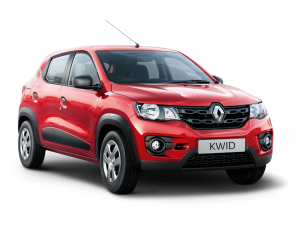

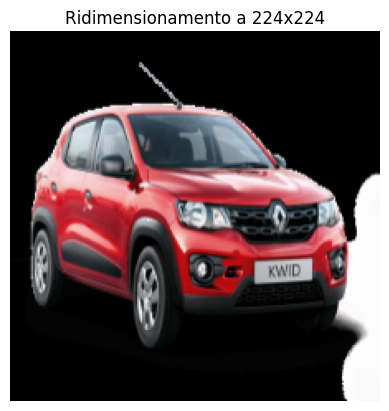

In [6]:
#path della cartella delle immagini
cartella_immagine = 'Dataset\images'
#crea il path dei dati facendo un join tra il path della cartella che contiene l'immagini e finiscono con *g quindi tutte quelle in formato png
data_path = os.path.join(cartella_immagine,'*g')
#La funzione glob mi restituisce una lista di file contentete quel path, quindi tutte le immagini png
files_immagini = glob.glob(data_path)
#si ordinano in ordine alfabetico per farle matchare con il rispettivo file xml, che contiene la label delle varie targhe
files_immagini.sort()
#contiene tutte le immagini in formato png con il nuovo size
for file in files_immagini:
    immagine = cv2.imread(file)
    immagine = cv2.resize(immagine, (SIZE_IMMAGINE,SIZE_IMMAGINE))
    #perché cv2 di default con il imread mi inverte i colori
    immagine_rgb = cv2.cvtColor(immagine, cv2.COLOR_BGR2RGB)
    LISTA_IMMAGINI.append(immagine_rgb)
    
#Per far vedere le dimensioni originali dell'immagine 116 all'interno del database confrontata con la medesima ma a dimensione 300x300
display(Image(files_immagini[116]))
plt.imshow(LISTA_IMMAGINI[116])
plt.axis('off')  # Turn off axis labels
plt.title("Ridimensionamento a 224x224")
plt.show()


ORA AVENDO NEL DATABASE ANCHE i FILE XML DELLE RISPETTIVE IMMAGINI CHE MI DANNO LE COORDINATE (xmin,xmax,ymin,ymax) DELLE LABEL DELLE TARGHE, DEVO A SUA VOLTA RIDIMENSIONARLE IN BASE ALLA SIZE_IMMAGINE.

In [7]:
def ridimensionamento_file_xml(file):
    albero = etree.parse(file)
    root = albero.getroot()
    #dimensione dell'immagine in xml
    dimensione  = root.find('size')
    larghezza = dimensione.find('width').text
    altezza = dimensione.find('height').text
    
    dimensione_coordinate = root.find('object').find('bndbox')
    larghezza,altezza = int(larghezza),int(altezza)
    xmin,ymin,xmax,ymax = int(dimensione_coordinate.find('xmin').text), int(dimensione_coordinate.find('ymin').text), int(dimensione_coordinate.find('xmax').text), int(dimensione_coordinate.find('ymax').text)
    
    xmin, ymin = xmin/(larghezza/SIZE_IMMAGINE), ymin/(altezza/SIZE_IMMAGINE)
    
    xmax, ymax = xmax/(larghezza/SIZE_IMMAGINE), ymax/(altezza/SIZE_IMMAGINE)
    
    return (int(xmin),int(ymin),int(xmax),int(ymax))

#Inizio a scorrere i file xml all'interno del dataset\annotations 
cartella_annotations = 'Dataset\\annotations'
xml_path = os.path.join(cartella_annotations,'*l')
files_xml = glob.glob(xml_path)
files_xml.sort()
for file_xml in files_xml:
    LISTA_LABEL.append(ridimensionamento_file_xml(file_xml))

#TEST FUNZIONE ridimensionamento_file_xml    
file = open('Dataset\\annotations\\Cars0.xml','r')
xmin,ymin,xmax,ymax = ridimensionamento_file_xml(file)
print(xmin,ymin,xmax,ymax)

print(LISTA_LABEL[0][0],LISTA_LABEL[0][1])


101 104 187 144
101 104


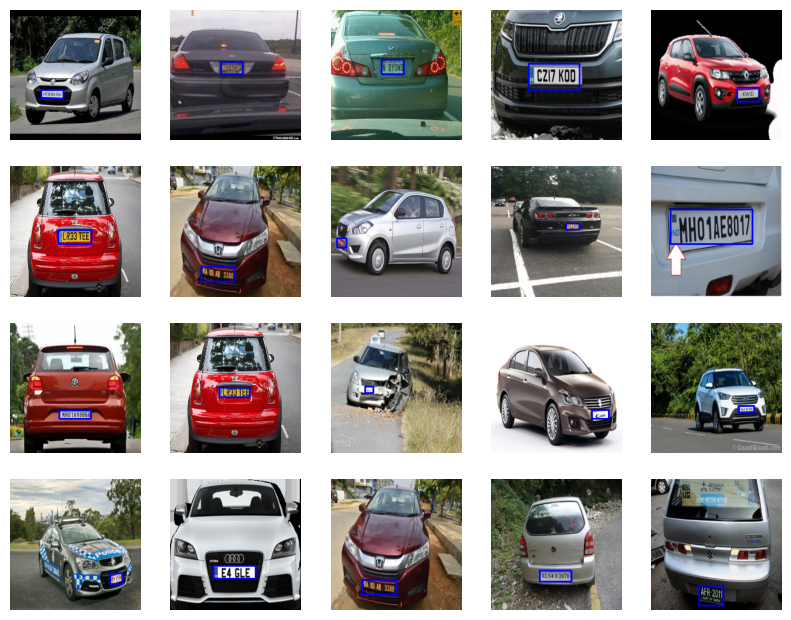

In [8]:
#ORA RIDISEGNO IL RETTANGOLO PER OGNI IMMAGINE CHE MI INDIVIDUA LA TARGA
i=0
for file in LISTA_IMMAGINI:
    xmin_i,ymin_i,xmax_i,ymax_i = LISTA_LABEL[i][0],LISTA_LABEL[i][1],LISTA_LABEL[i][2],LISTA_LABEL[i][3]
    immagine_con_rettangolo = cp.deepcopy(file)
    cv2.rectangle(immagine_con_rettangolo,(xmin_i,ymin_i),(xmax_i,ymax_i),(0,0,255),2)
    LISTA_IMMAGINI_CON_LABEL.append(immagine_con_rettangolo)
    i=i+1

#un subplot della 100-esima immagine fino alla 120-esima.
plt.figure(figsize=(10,20))
for i in range(0,20) :
    plt.subplot(10,5,i+1)
    plt.axis('off')
    plt.imshow(LISTA_IMMAGINI_CON_LABEL[120-i])        

    

CONVOLUTIONAL NEURAL NETWORK.

In [9]:
#Preparazione dati e transformazione in numpyarray
LISTA_IMMAGINI = np.array(LISTA_IMMAGINI)
LISTA_LABEL = np.array(LISTA_LABEL)
#Normalizzazione delle due liste, cosi da avere valori pixel nell'intervallo [0,1], e quindi rende addestramento della rete + semplice
LISTA_IMMAGINI = LISTA_IMMAGINI/255
LISTA_LABEL = LISTA_LABEL/255

#TRAINING SET:70%, VALIDATION SET:10%, TEST SET:20%
#CREAZIONE del training set delle immagini e delle label e anche del testset dove corrisponde al 20% del DATASET.
immagini_train_temp, immagini_test_set, labels_train_temp, labels_test_set = train_test_split(LISTA_IMMAGINI,LISTA_LABEL,test_size=0.2,random_state=42)
#SUDDIVISIONE ulteriore del training set per creare il VALIDATION SET 
immagini_train,immagini_val,labels_train,labels_val = train_test_split(immagini_train_temp,labels_train_temp,test_size=0.1,random_state=42)


In [10]:
#CREAZIONE modello sequenziale, dove ci aggiungo la rete VGG già preaddestrata con i pesi della imagenet, levando l'ultimo suo layer FC per sostituirlo con
#i fulli creati da me dopo, e avente come dimensione(input) proprio il SIZE_IMMAGINE.
model = Sequential()
input_layer = Input(shape=(SIZE_IMMAGINE, SIZE_IMMAGINE, 3))
vgg_model = VGG16(weights="imagenet", include_top=False, input_tensor=input_layer)
model.add(vgg_model)
model.add(Flatten())
model.add(Dense(128, activation="relu"))
model.add(Dropout(0.3))
model.add(Dense(128, activation="relu"))
model.add(Dense(64, activation="relu"))
#4 perché devo predirre solo le coordinate di xmin,ymin,xmax,ymax
model.add(Dense(4, activation="sigmoid"))  #utilizzo della sigmoid per la regressione, altrimenti dovevo utilizzare softmax per classificazione

model.layers[-6].trainable = False  #evito l'addestramento dei primi layer del VGG16

model.summary()



Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 128)               3211392   
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 128)               16512     
                                                                 
 dense_2 (Dense)             (None, 64)                8256      
                                                                 
 dense_3 (Dense)             (None, 4)                

In [11]:
#Ora si configura il modello con la il suo optimizer e funzione di loss MSE (Mean Squared Error),optimizer adam e metrica l'accuracy
model.compile(optimizer='adam', loss='mean_squared_error',metrics=['accuracy'])

In [12]:
#verbose=1 mi indicca lo scorrimento della barra nel completamento di una epoca
model.fit(immagini_train,labels_train,batch_size=32, epochs=NUMERO_EPOCHE,verbose=1,validation_data=(immagini_val,labels_val))

Epoch 1/50


 2/10 [=====>........................] - ETA: 4:00 - loss: 0.0996 - accuracy: 0.3438

In [ ]:
file_name_model = 'mymodel.sav'

# Salvare il modello
with open(file_name_model, 'wb') as file:
    pickle.dump(model, file)

# Caricare il modello
with open(file_name_model, 'rb') as file:
    loaded_model = pickle.load(file)

# Calcolare gli score del modello sul TEST SET
scores = loaded_model.evaluate(immagini_test_set, labels_test_set, verbose=0)
print("Score: %.2f%%" % (scores[1] * 100))


In [ ]:
#Visualizzazione del risultato.
label_cnn = loaded_model.predict(immagini_test_set)

In [ ]:
plt.figure(figsize=(20,40))
for i in range(0,43) :
    plt.subplot(10,5,i+1)
    plt.axis('off')
    ny = label_cnn[i]*255
    image = cv2.rectangle(immagini_test_set[i],(int(ny[0]),int(ny[1])),(int(ny[2]),int(ny[3])),(0, 255, 0))
    plt.imshow(image)